In [16]:
import pandas as pd
import numpy as np
import os
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
CATEGORIES = ['cats', 'dogs']
EPOCHS = 50
TEST_SET = 0.30


In [17]:
def LoadDataFromDirectory(dataDir : str):
    images = []
    labels = []
    for Category in CATEGORIES:
        singleCategory = os.path.join(dataDir, str(Category))
        
        for image in os.listdir(singleCategory):
            imagsPaths = os.path.join(singleCategory, image)
            
            finalImages = cv2.imread(imagsPaths)
            
            if finalImages is None:
                raise Exception("The directory is null or Empty")
            
            #64 x 64
            img = cv2.resize(finalImages, (64,64))
            images.append(img)
            labels.append(CATEGORIES.index(Category))
    
    return (np.array(images), np.array(labels))
            
        

In [18]:
images, labels = LoadDataFromDirectory("CatsVsDogs/train")

X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(images), np.array(labels), test_size=TEST_SET, shuffle=True
)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")


X train shape: (14000, 64, 64, 3)
Y train shape: (14000,)
X test shape: (6000, 64, 64, 3)
Y test shape: (6000,)


In [19]:
def RestNet50(input_shape = (64,64,3), classes=2, training=False):
    X_input = keras.Input(shape=input_shape)
    
    X = keras.layers.ZeroPadding2D((3,3))(X_input)
    
    #First Block
    Z1 = keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=2)(X)
    B1 = keras.layers.BatchNormalization(axis=3)(Z1)
    A1 = keras.layers.ReLU()(B1)
    P1 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid")(A1)
    
    #Second Block
    Z2 = keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2)(P1)
    B2 = keras.layers.BatchNormalization(axis=3)(Z2)
    A2 = keras.layers.ReLU()(B2)
    P2 = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding="same")(A2)
    
    X_FLATTEN = keras.layers.Flatten()(P2)
    output = keras.layers.Dense(units=classes, activation="softmax")(X_FLATTEN)
    
    model = keras.Model(X_input, output)
    
    return model
    

In [20]:
ConvModel = RestNet50((64,64,3), 2)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

# Compilar
ConvModel.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

Y_train_cat = to_categorical(Y_train, num_classes=2)
Y_test_cat  = to_categorical(Y_test, num_classes=2)

history = ConvModel.fit(X_train, Y_train_cat, epochs=EPOCHS, batch_size=32, validation_data=(X_test, Y_test_cat), callbacks=callbacks)
ConvModel.summary()

Epoch 1/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5350 - loss: 0.8194
Epoch 1: val_loss improved from None to 0.71124, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.5594 - loss: 0.7659 - val_accuracy: 0.5883 - val_loss: 0.7112 - learning_rate: 1.0000e-05
Epoch 2/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5994 - loss: 0.6927
Epoch 2: val_loss improved from 0.71124 to 0.66104, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.6126 - loss: 0.6786 - val_accuracy: 0.6277 - val_loss: 0.6610 - learning_rate: 1.0000e-05
Epoch 3/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6393 - loss: 0.6425
Epoch 3: val_loss improved from 0.66104 to 0.64042, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.6426 - loss: 0.6418 - val_accuracy: 0.6492 - val_loss: 0.6404 - learning_rate: 1.0000e-05
Epoch 4/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6593 - loss: 0.6239
Epoch 4: val_loss improved from 0.64042 to 0.62370, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.6655 - loss: 0.6158 - val_accuracy: 0.6648 - val_loss: 0.6237 - learning_rate: 1.0000e-05
Epoch 5/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6743 - loss: 0.6023
Epoch 5: val_loss improved from 0.62370 to 0.60876, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.6794 - loss: 0.5968 - val_accuracy: 0.6788 - val_loss: 0.6088 - learning_rate: 1.0000e-05
Epoch 6/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6870 - loss: 0.5893
Epoch 6: val_loss improved from 0.60876 to 0.60491, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.6913 - loss: 0.5825 - val_accuracy: 0.6785 - val_loss: 0.6049 - learning_rate: 1.0000e-05
Epoch 7/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7054 - loss: 0.5692
Epoch 7: val_loss improved from 0.60491 to 0.58837, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.7052 - loss: 0.5686 - val_accuracy: 0.6958 - val_loss: 0.5884 - learning_rate: 1.0000e-05
Epoch 8/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7140 - loss: 0.5549
Epoch 8: val_loss improved from 0.58837 to 0.57970, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7156 - loss: 0.5559 - val_accuracy: 0.6987 - val_loss: 0.5797 - learning_rate: 1.0000e-05
Epoch 9/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7264 - loss: 0.5396
Epoch 9: val_loss improved from 0.57970 to 0.57475, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.7225 - loss: 0.5460 - val_accuracy: 0.7058 - val_loss: 0.5748 - learning_rate: 1.0000e-05
Epoch 10/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7284 - loss: 0.5440
Epoch 10: val_loss did not improve from 0.57475
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7307 - loss: 0.5384 - val_accuracy: 0.6998 - val_loss: 0.5834 - learning_rate: 1.0000e-05
Epoch 11/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7350 - loss: 0.5259
Epoch 11: val_loss improved from 0.57475 to 0.56357, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7332 - loss: 0.5294 - val_accuracy: 0.7152 - val_loss: 0.5636 - learning_rate: 1.0000e-05
Epoch 12/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7418 - loss: 0.5219
Epoch 12: val_loss improved from 0.56357 to 0.55759, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7426 - loss: 0.5200 - val_accuracy: 0.7218 - val_loss: 0.5576 - learning_rate: 1.0000e-05
Epoch 13/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7455 - loss: 0.5174
Epoch 13: val_loss did not improve from 0.55759
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7513 - loss: 0.5140 - val_accuracy: 0.7133 - val_loss: 0.5639 - learning_rate: 1.0000e-05
Epoch 14/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7478 - loss: 0.5099
Epoch 14: val_loss improved from 0.55759 to 0.55094, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.7532 - loss: 0.5066 - val_accuracy: 0.7270 - val_loss: 0.5509 - learning_rate: 1.0000e-05
Epoch 15/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7580 - loss: 0.4999
Epoch 15: val_loss improved from 0.55094 to 0.54777, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.7590 - loss: 0.4999 - val_accuracy: 0.7270 - val_loss: 0.5478 - learning_rate: 1.0000e-05
Epoch 16/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7663 - loss: 0.4912
Epoch 16: val_loss improved from 0.54777 to 0.54429, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.7630 - loss: 0.4935 - val_accuracy: 0.7330 - val_loss: 0.5443 - learning_rate: 1.0000e-05
Epoch 17/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7715 - loss: 0.4856
Epoch 17: val_loss improved from 0.54429 to 0.54009, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7686 - loss: 0.4871 - val_accuracy: 0.7352 - val_loss: 0.5401 - learning_rate: 1.0000e-05
Epoch 18/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7731 - loss: 0.4873
Epoch 18: val_loss improved from 0.54009 to 0.53917, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7724 - loss: 0.4823 - val_accuracy: 0.7375 - val_loss: 0.5392 - learning_rate: 1.0000e-05
Epoch 19/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7760 - loss: 0.4797
Epoch 19: val_loss improved from 0.53917 to 0.53663, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.7782 - loss: 0.4749 - val_accuracy: 0.7363 - val_loss: 0.5366 - learning_rate: 1.0000e-05
Epoch 20/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7787 - loss: 0.4750
Epoch 20: val_loss improved from 0.53663 to 0.53293, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.7828 - loss: 0.4699 - val_accuracy: 0.7428 - val_loss: 0.5329 - learning_rate: 1.0000e-05
Epoch 21/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7744 - loss: 0.4713
Epoch 21: val_loss did not improve from 0.53293
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7821 - loss: 0.4653 - val_accuracy: 0.7372 - val_loss: 0.5369 - learning_rate: 1.0000e-05
Epoch 22/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7926 - loss: 0.4583
Epoch 22: val_loss improved from 0.53293 to 0.53036, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7890 - loss: 0.4593 - val_accuracy: 0.7430 - val_loss: 0.5304 - learning_rate: 1.0000e-05
Epoch 23/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7891 - loss: 0.4514
Epoch 23: val_loss did not improve from 0.53036
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7897 - loss: 0.4545 - val_accuracy: 0.7377 - val_loss: 0.5349 - learning_rate: 1.0000e-05
Epoch 24/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7986 - loss: 0.4443
Epoch 24: val_loss improved from 0.53036 to 0.52477, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.7957 - loss: 0.4490 - val_accuracy: 0.7498 - val_loss: 0.5248 - learning_rate: 1.0000e-05
Epoch 25/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7967 - loss: 0.4422
Epoch 25: val_loss improved from 0.52477 to 0.52205, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7955 - loss: 0.4440 - val_accuracy: 0.7502 - val_loss: 0.5221 - learning_rate: 1.0000e-05
Epoch 26/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7993 - loss: 0.4408
Epoch 26: val_loss improved from 0.52205 to 0.52118, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.7996 - loss: 0.4407 - val_accuracy: 0.7503 - val_loss: 0.5212 - learning_rate: 1.0000e-05
Epoch 27/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8054 - loss: 0.4348
Epoch 27: val_loss did not improve from 0.52118
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8025 - loss: 0.4357 - val_accuracy: 0.7395 - val_loss: 0.5361 - learning_rate: 1.0000e-05
Epoch 28/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8030 - loss: 0.4344
Epoch 28: val_loss did not improve from 0.52118
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.8047 - loss: 0.4319 - val_accuracy: 0.7453 - val_loss: 0.5259 - learning_rate: 1.0000e-05
Epoch 29/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8097 - loss: 0.4264
Epoch 29: val_loss improved from 0.52118 to 0.51640, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8072 - loss: 0.4278 - val_accuracy: 0.7518 - val_loss: 0.5164 - learning_rate: 1.0000e-05
Epoch 30/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8135 - loss: 0.4213
Epoch 30: val_loss improved from 0.51640 to 0.51535, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8116 - loss: 0.4218 - val_accuracy: 0.7542 - val_loss: 0.5153 - learning_rate: 1.0000e-05
Epoch 31/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8173 - loss: 0.4149
Epoch 31: val_loss did not improve from 0.51535
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.8129 - loss: 0.4195 - val_accuracy: 0.7288 - val_loss: 0.5485 - learning_rate: 1.0000e-05
Epoch 32/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8158 - loss: 0.4122
Epoch 32: val_loss did not improve from 0.51535
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.8144 - loss: 0.4145 - val_accuracy: 0.7413 - val_loss: 0.5364 - learning_rate: 1.0000e-05
Epoch 33/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8185 - loss: 0.4111
Epoch 33: val_loss improved from 0.51535 to 0.51087, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8163 - loss: 0.4123 - val_accuracy: 0.7565 - val_loss: 0.5109 - learning_rate: 1.0000e-05
Epoch 34/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8202 - loss: 0.4105
Epoch 34: val_loss did not improve from 0.51087
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8191 - loss: 0.4099 - val_accuracy: 0.7515 - val_loss: 0.5179 - learning_rate: 1.0000e-05
Epoch 35/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8266 - loss: 0.4017
Epoch 35: val_loss did not improve from 0.51087
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8212 - loss: 0.4067 - val_accuracy: 0.7438 - val_loss: 0.5340 - learning_rate: 1.0000e-05
Epoch 36/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8242 - loss: 0.4007
Epoch 36: val_loss improved from 0.51087 to 0.50559, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.8238 - loss: 0.4023 - val_accuracy: 0.7627 - val_loss: 0.5056 - learning_rate: 1.0000e-05
Epoch 37/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8284 - loss: 0.3992
Epoch 37: val_loss improved from 0.50559 to 0.50465, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8276 - loss: 0.3995 - val_accuracy: 0.7592 - val_loss: 0.5047 - learning_rate: 1.0000e-05
Epoch 38/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8329 - loss: 0.3888
Epoch 38: val_loss did not improve from 0.50465
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8285 - loss: 0.3959 - val_accuracy: 0.7567 - val_loss: 0.5146 - learning_rate: 1.0000e-05
Epoch 39/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8331 - loss: 0.3888
Epoch 39: val_loss improved from 0.50465 to 0.50273, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8311 - loss: 0.3924 - val_accuracy: 0.7617 - val_loss: 0.5027 - learning_rate: 1.0000e-05
Epoch 40/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8320 - loss: 0.3878
Epoch 40: val_loss did not improve from 0.50273
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8347 - loss: 0.3875 - val_accuracy: 0.7615 - val_loss: 0.5066 - learning_rate: 1.0000e-05
Epoch 41/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8287 - loss: 0.3921
Epoch 41: val_loss did not improve from 0.50273
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8338 - loss: 0.3861 - val_accuracy: 0.7615 - val_loss: 0.5096 - learning_rate: 1.0000e-05
Epoch 42/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8401 - loss: 0.3786
Epoch 42: val_loss did not improve from 0.50273
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8367 - loss: 0.3822 - val_accuracy: 0.7565 - val_loss: 0.5102 - learning_rate: 1.0000e-05
Epoc

438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8424 - loss: 0.3742 - val_accuracy: 0.7645 - val_loss: 0.4991 - learning_rate: 5.0000e-06
Epoch 45/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8418 - loss: 0.3771
Epoch 45: val_loss did not improve from 0.49911
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8434 - loss: 0.3726 - val_accuracy: 0.7682 - val_loss: 0.5023 - learning_rate: 5.0000e-06
Epoch 46/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8372 - loss: 0.3723
Epoch 46: val_loss did not improve from 0.49911
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 71ms/step - accuracy: 0.8421 - loss: 0.3710 - val_accuracy: 0.7647 - val_loss: 0.5004 - learning_rate: 5.0000e-06
Epoch 47/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8405 - loss: 0.3755
Epoch 47: val_loss did not improve from 0.49911
438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8459 - loss: 0.3694 - val_accuracy: 0.7588 - val_loss: 0.5034 - learning_rate: 5.0000e-06
Epoc

438/438 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.8458 - loss: 0.3674 - val_accuracy: 0.7617 - val_loss: 0.4991 - learning_rate: 5.0000e-06
Epoch 49/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8513 - loss: 0.3644
Epoch 49: val_loss improved from 0.49907 to 0.49871, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.8479 - loss: 0.3665 - val_accuracy: 0.7658 - val_loss: 0.4987 - learning_rate: 2.5000e-06
Epoch 50/50
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8544 - loss: 0.3628
Epoch 50: val_loss improved from 0.49871 to 0.49762, saving model to best_model.h5


438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.8486 - loss: 0.3656 - val_accuracy: 0.7650 - val_loss: 0.4976 - learning_rate: 2.5000e-06
Restoring model weights from the end of the best epoch: 50.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 70, 70, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 32)       │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,320 (505.16 KB)

 Trainable params: 43,042 (168.13 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 86,086 (336.28 KB)

/var/folders/64/_d7wbs111535lmdv26qfwp000000gn/T/ipykernel_5681/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/64/_d7wbs111535lmdv26qfwp000000gn/T/ipykernel_5681/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

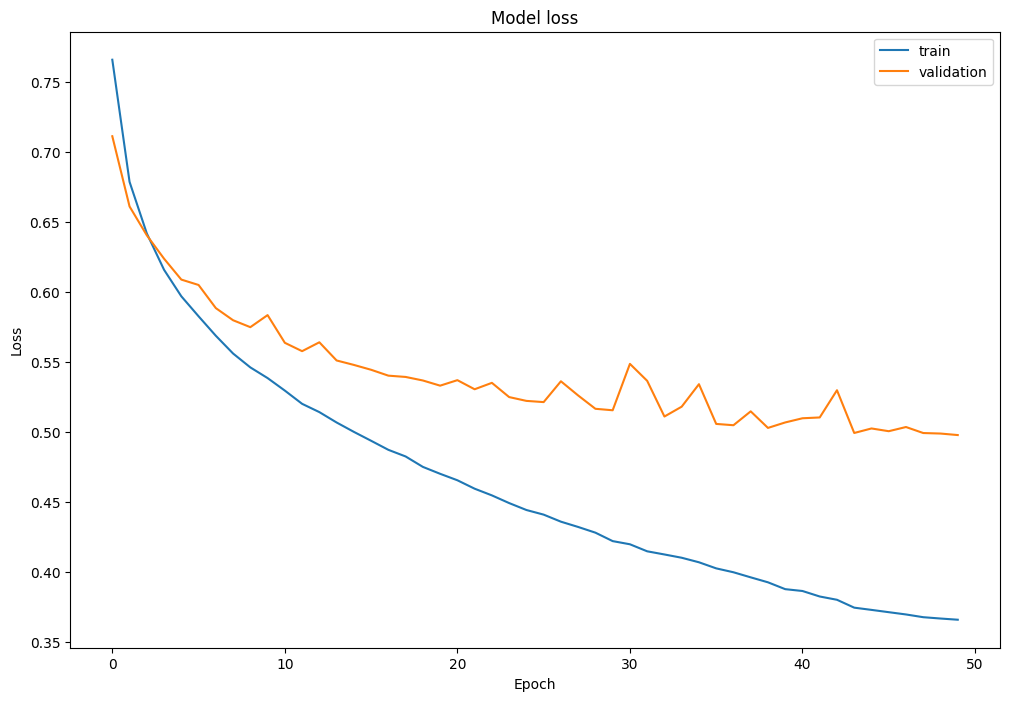

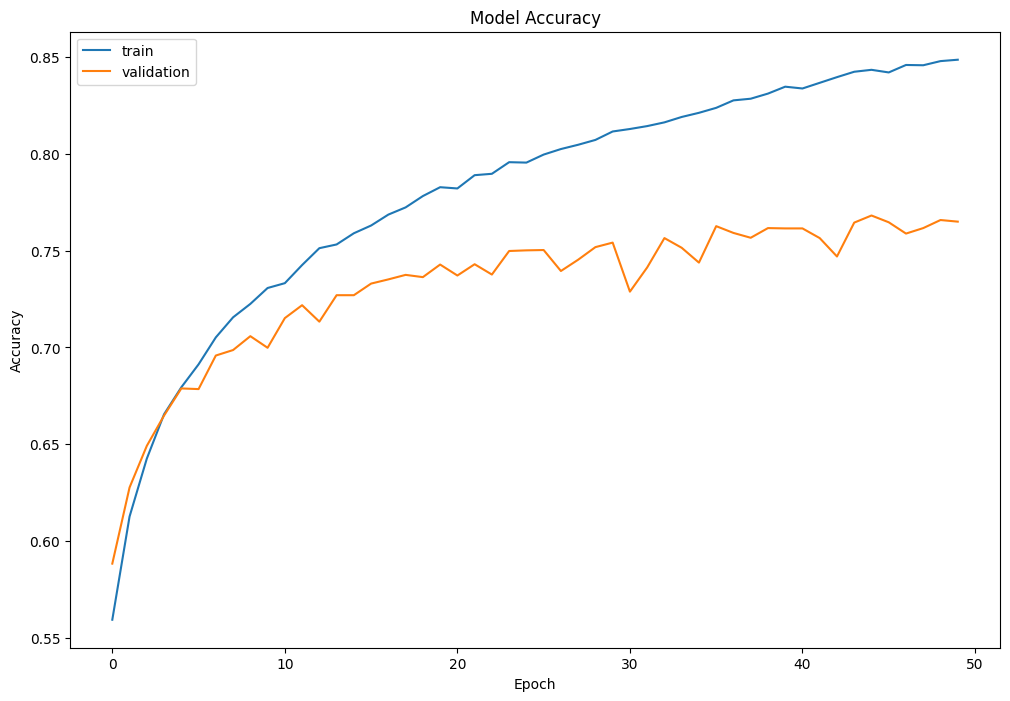

In [21]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [23]:
train_loss , train_accuracy = ConvModel.evaluate(X_train, Y_train_cat)
test_loss, test_accuracy = ConvModel.evaluate(X_test, Y_test_cat)

print(f"The train accuracy {train_accuracy}")
print(f"The test accuracy {test_accuracy}")

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8526 - loss: 0.3597
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7650 - loss: 0.4976
The train accuracy 0.852642834186554
The test accuracy 0.7649999856948853
